## Read a netCDF file and make movie with cartopy using a function testing different colomaps (cmcrameri package)

- see https://pypi.org/project/cmcrameri/#description

Choose kernel env-gloenv310-cmcrameri

- see http://intranet.cerfacs.fr/intranet_equipes/globc/PDFTEAMTUTORIALS/Virtual_python_environment_scylla_kraken.pdf

The core concept is that the projection of your axes is independent of the coordinate system your data is defined in. **The projection argument is used when creating plots and determines the projection of the resulting plot (i.e. what the plot looks like). The transform argument to plotting functions tells Cartopy what coordinate system your data are defined in.**


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib import colormaps
import cmcrameri 
from cmcrameri import show_cmaps
from cmcrameri.cm import paths
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import time as t

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/pyproj/__init__.py:92: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
# Useful functions
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def get_lon_name(ds):
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")

In [3]:
begin = t.time()

In [4]:
var_ini='tas'
ds=xr.open_mfdataset('/archive/globc/datamg/globc_obs/ERA5/'+var_ini+'_1m_194001-202212_ERA5.nc')

In [5]:
output_dir='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/animations/'

In [6]:
ds[var_ini]

<xarray.DataArray 'tas' (time: 996, latitude: 721, longitude: 1440)>
dask.array<open_dataset-683094a50840370ee2cc13703099629btas, shape=(996, 721, 1440), dtype=float32, chunksize=(996, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    long_name:  2 metre temperature
    units:      K

In [7]:
#ds.keys()

In [8]:
# Read the data and coordinate variables.
lon_name = get_lon_name(ds)
print(lon_name)
lat_name = get_lat_name(ds)
print(lat_name)
lon = ds.coords[lon_name]
#print(lon)
lat = ds.coords[lat_name]
#print(lat)
var = ds[var_ini][:]
#print(var)

longitude
latitude


In [9]:
# Set the path of the ffmpeg binary
ffmpeg_path = '/data/softs/local/ffmpeg/4.2.1/bin/ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

In [ ]:
list(colormaps)

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


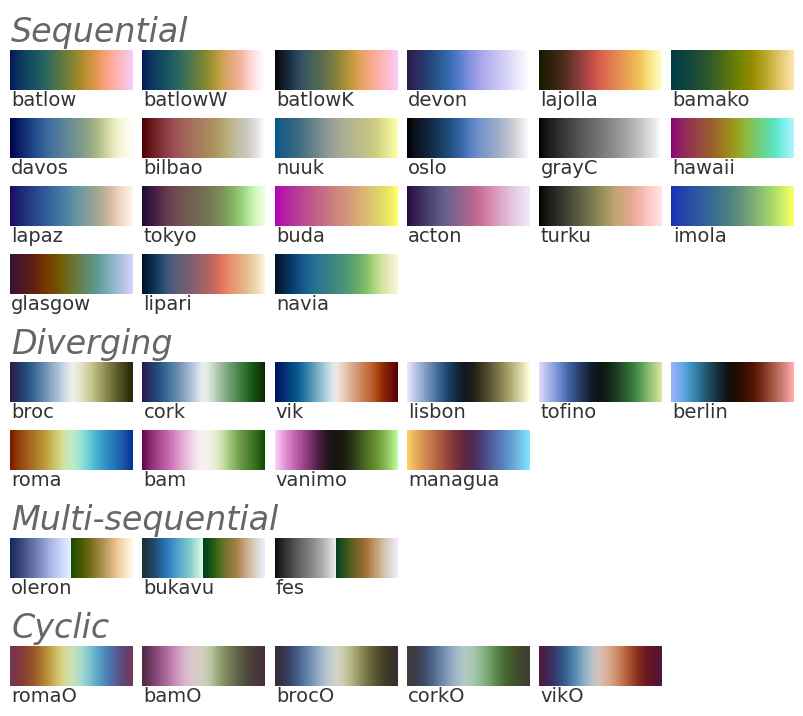

In [10]:
show_cmaps()

In [11]:
#paths

In [12]:
# Set plotting parameters
# -----------------------
# Use the dictionary `plot_parameter` to define some plot settings.
plot_parameter = {}
plot_parameter['extent'] = [-180, 180, -90, 90]
plot_parameter['projection'] = ccrs.PlateCarree()
plot_parameter['vmin'] = var.min().values
# np.min(var)
plot_parameter['vmax'] = var.max().values
plot_parameter['cmap'] = 'cmc.batlow'
plot_parameter['title'] = var.long_name

In [13]:
# Get number of frames
# --------------------
# The input dataset contains 996 time steps and we want to create the animation
# over all.
frames = ds.time.size
print("frames :", frames)

frames : 996


In [14]:
# Get date strings
# ----------------
# The date string should be added on top of the plot and therefore we get the
# date strings in a nicer notation.
time_str = ds.time.dt.strftime('%Y-%m-%d').data

In [15]:
#------------------------------------------------------------------------------
# Define function plot_init()
#
# This function is needed as input for the `init_func` parameter of
# Matplotlib's `FuncAnimation`. It presets in this case the extent of the
# map, the title  and coastline drawing.
#------------------------------------------------------------------------------
def plot_init():
    ax.set_extent(plot_parameter['extent'])
    ax.coastlines()
    plt.title(plot_parameter['title'], fontsize=15)
    return plot


In [16]:
#------------------------------------------------------------------------------
# Define function update_frame()
#
# This is the function that is called for each time step (frame) to generate
# the corresponding plot.
# Instead of creating a new plot for each time step, we only exchange the
# data array for the plot in the `update_frame()` function with Matplotlib's
# `plot.set_array()` method. This makes the creation of the animation much
# faster
#------------------------------------------------------------------------------
def update_frame(frame):
    plot.set_array(np.array(var[frame,:,:]).ravel())
    tx.set_text(time_str[frame])
    return plot, tx

/data/softs/anaconda3-2020.07/envs/gloenv_py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


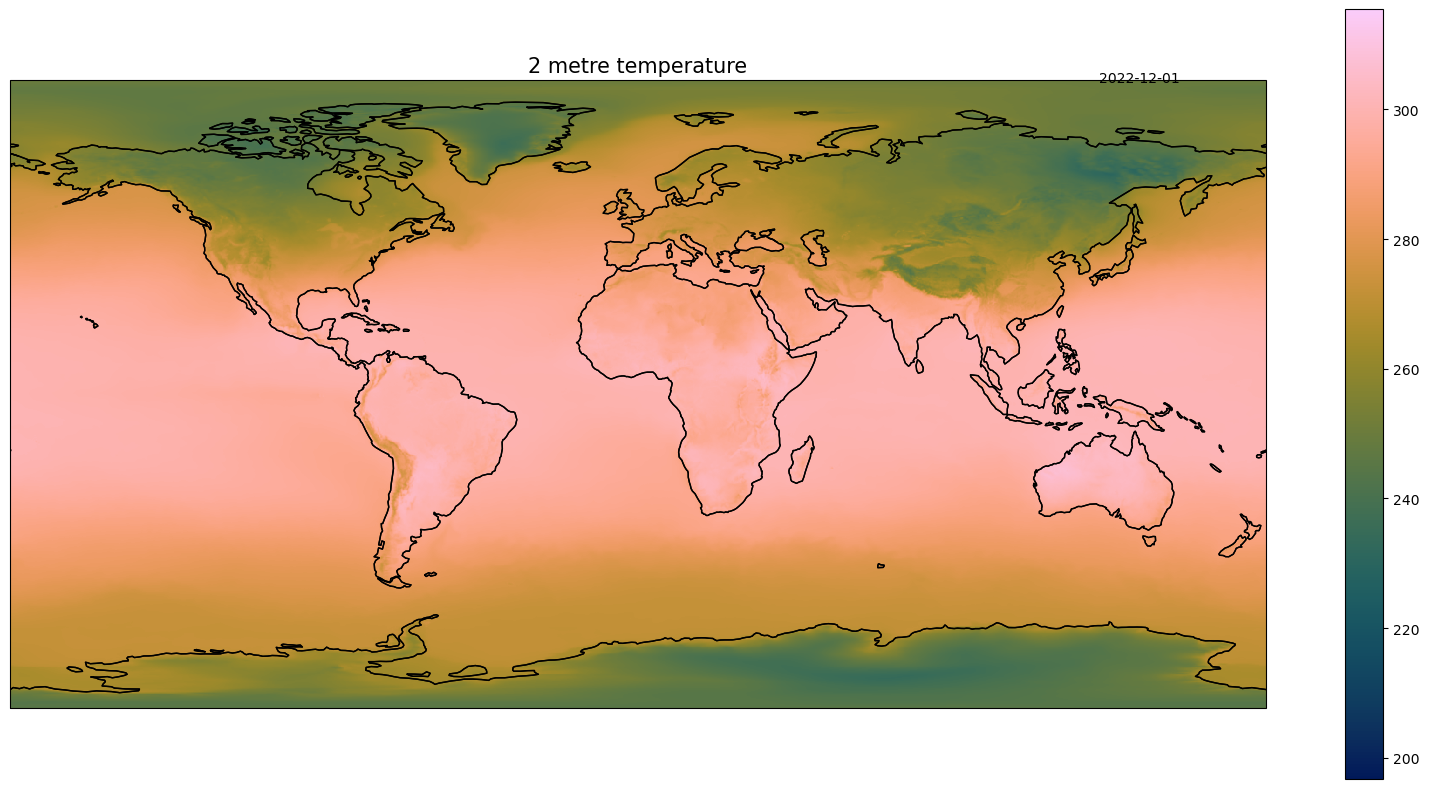

In [17]:
# Create the animation 
# ----------------------
# Now, we can generate the animation doing the following steps:
#
# 1. define figure and axis
# 2. create the plot object for the first time step
# 3. add a colorbar
# 4. add the date string on top
# 5. create the animation in memory
# 6. save the animation to a mp4 file encoded using the MPEG-4 standard
fig, ax = plt.subplots(figsize=(16,8),
                       subplot_kw={"projection": plot_parameter['projection']})

plot = ax.pcolormesh(lon, lat, var[0,:,:],
                     cmap=plot_parameter['cmap'],
                     vmin=plot_parameter['vmin'],
                     vmax=plot_parameter['vmax'])
cb = plt.colorbar(plot)
tx = fig.text(0.69, 0.89, time_str[0])

ani = FuncAnimation(fig, update_frame, frames=range(0, frames),
                     init_func=plot_init)

ani.save(output_dir+'tas_animation_batlow.mp4',
         writer=animation.FFMpegWriter(fps=60, bitrate=5000, codec='h264'),
         dpi=100)


In [18]:
end = t.time()
print('Runtime to calculate the weights is', '{0:.1f}'.format(end - begin), 's')

Runtime to calculate the weights is 1043.5 s
